In [6]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import datetime
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn import linear_model as lm
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt

                Id  MSSubClass    MSZoning  LotFrontage       LotArea  \
count   730.000000  730.000000  730.000000   730.000000    730.000000   
mean   1095.500000   56.547945    3.020548    57.169863  10092.143836   
std     210.877136   41.198619    0.600288    36.361524   5530.730034   
min     731.000000   20.000000    0.000000     0.000000   1300.000000   
25%     913.250000   20.000000    3.000000    40.000000   7599.250000   
50%    1095.500000   50.000000    3.000000    61.000000   9484.500000   
75%    1277.750000   70.000000    3.000000    78.000000  11509.000000   
max    1460.000000  190.000000    4.000000   313.000000  63887.000000   

           Street       Alley    LotShape  LandContour   Utilities  \
count  730.000000  730.000000  730.000000   730.000000  730.000000   
mean     0.995890   -0.913699    1.964384     2.780822    0.001370   
std      0.064018    0.365830    1.405005     0.705584    0.037012   
min      0.000000   -1.000000    0.000000     0.000000    0.00

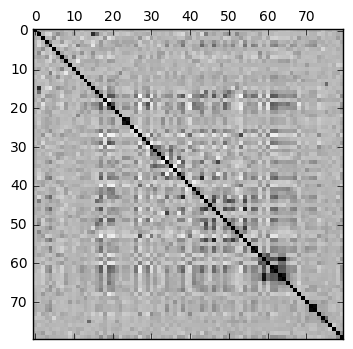

In [8]:
#https://www.kaggle.com/c/house-prices-advanced-regression-techniques

original_train_data = pd.read_csv('data/train.csv',delimiter=',',header=0)
original_test_data = pd.read_csv('data/test.csv',delimiter=',',header=0)

# train data; convert categoricals to integers
obj_columns = original_train_data.select_dtypes(['object']).columns
original_train_data[obj_columns] = original_train_data[obj_columns].apply(lambda x: x.astype('category').cat.codes)
original_train_data = original_train_data.fillna(value=0)

# test data; convert categoricals to integers
obj_columns = original_test_data.select_dtypes(['object']).columns
original_test_data[obj_columns] = original_test_data[obj_columns].apply(lambda x: x.astype('category').cat.codes)
original_test_data = original_test_data.fillna(value=0)

testdev_split = (len(original_train_data))/2

train_data = original_train_data.copy()[testdev_split:]
train_labels = train_data["SalePrice"].copy()
train_data = train_data.drop( ["SalePrice"], axis=1 )

dev_data = original_train_data.copy()[:testdev_split]
dev_labels = dev_data["SalePrice"].copy()
dev_data = dev_data.drop( ["SalePrice"], axis=1 )

test_data = original_test_data.copy()

# check data quality
print train_data.describe()

# check for correlation between features
corr = train_data.corr()
plt.matshow(corr, cmap=plt.cm.Greys)

<< Training data size >>

<< Unique contents sorted >>
TotRmsAbvGrd [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Functional [0, 1, 2, 3, 4, 6]
Fireplaces [0, 1, 2, 3]
FireplaceQu [-1, 0, 1, 2, 3, 4]
GarageType [-1, 0, 1, 2, 3, 4, 5]
GarageYrBlt [0.0, 1908.0, 1910.0, 1914.0, 1916.0, 1920.0, 1921.0, 1922.0, 1923.0, 1925.0, 1926.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1938.0, 1939.0, 1940.0, 1941.0, 1942.0, 1945.0, 1946.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0]
GarageFinish [-1, 0, 1, 2]
GarageCars [0, 1, 2, 

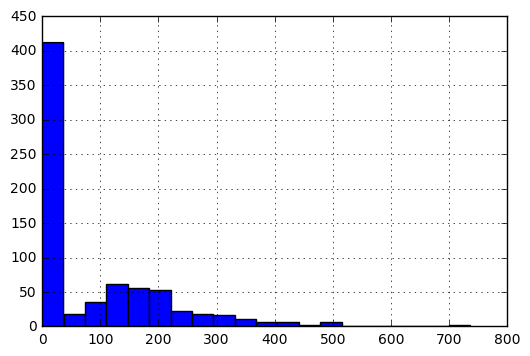

In [9]:
##
## JV DATA ANALYSIS
## Contents and Skew
##
part3_columns = ['TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
part3_train_data_cols = train_data.loc[:,part3_columns]
    
print "<< Training data size >>"
print
print "<< Unique contents sorted >>"
for colname in part3_train_data_cols:
    contents = train_data[colname].unique()
    print colname, sorted(contents)
print
print "<< NA's & zeroes counted >>"
for colname in part3_train_data_cols:
    na_count = train_data[colname].isnull().sum()
    zero_count = len(train_data[colname]) - len(train_data[colname].nonzero()[0])
    print colname, na_count + zero_count


#IDEAS

: Dlb-check category conversion...NaN = 0 after, but before?; address?
: Check distributions; adjust skew if necessary
: Normalization/scaling


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


               TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu  GarageType  \
TotRmsAbvGrd       1.000000   -0.081908    0.345083     0.316099   -0.049463   
Functional        -0.081908    1.000000   -0.010933    -0.008031   -0.104481   
Fireplaces         0.345083   -0.010933    1.000000     0.853928   -0.141404   
FireplaceQu        0.316099   -0.008031    0.853928     1.000000   -0.166340   
GarageType        -0.049463   -0.104481   -0.141404    -0.166340    1.000000   
GarageYrBlt        0.051798    0.025759    0.179309     0.181660    0.363022   
GarageFinish      -0.139444   -0.115637   -0.139277    -0.167324    0.579059   
GarageCars         0.307588    0.070877    0.290849     0.297476    0.033095   
GarageArea         0.301071    0.047390    0.274816     0.250211    0.032150   
GarageQual         0.040716    0.009237    0.166536     0.164315    0.233213   
GarageCond         0.047083    0.012582    0.192268     0.189491    0.248482   
PavedDrive        -0.037811    0.006835 

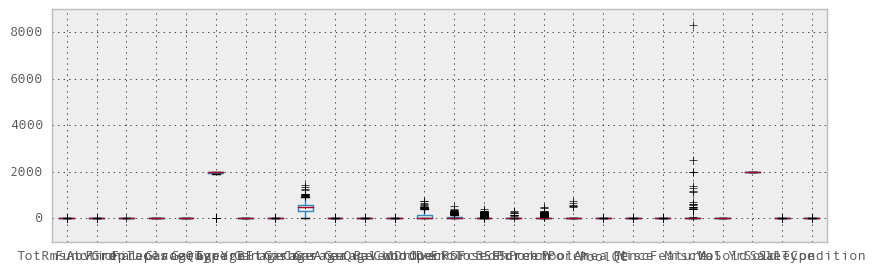

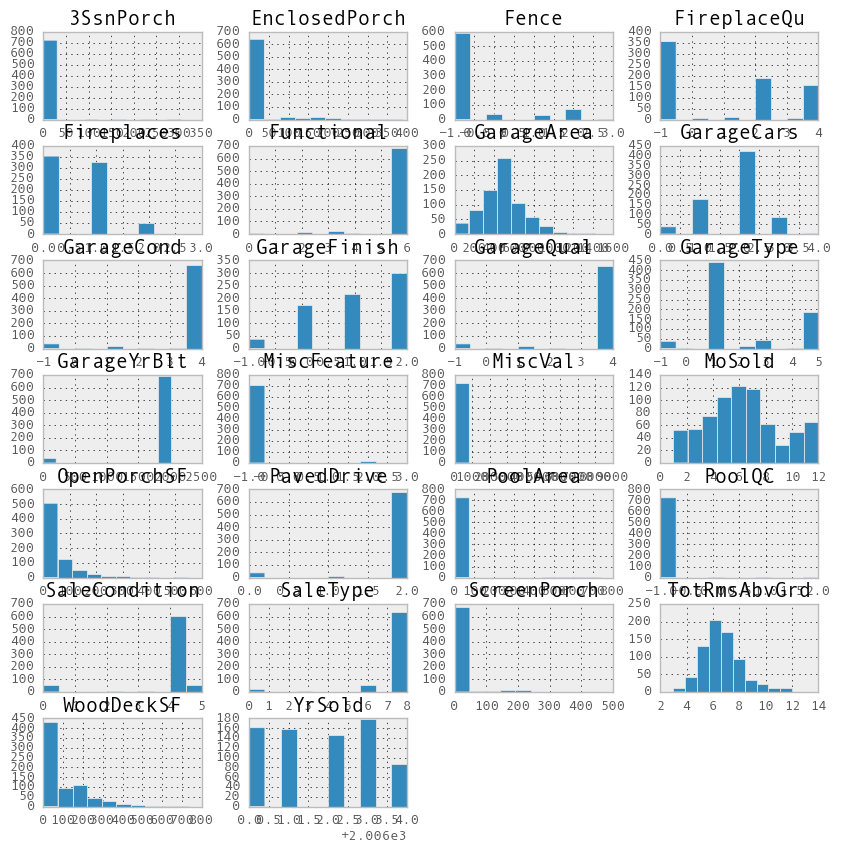

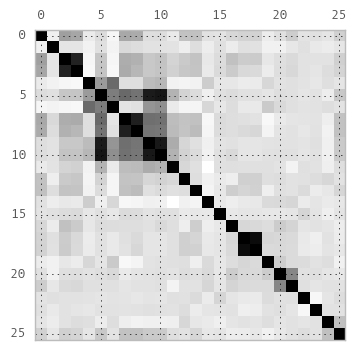

In [46]:

part3_data = train_data[train_data.columns[-26:]]

# box/whisker / feature
pd.options.display.mpl_style = 'default'
plt.figure(figsize=(10,3))
part3_data.boxplot();

# histograms by feature
part3_data.hist(figsize=(10,10),layout=(7,4));

# plot correlation matrix
pd.set_option('display.max_columns', None) 
corr = part3_data.corr()
plt.matshow(corr, cmap=plt.cm.Greys)
print corr


In [10]:
reg = LinearRegression()
reg.fit(train_data, train_labels)
print "Coefficients: " + str(reg.coef_)
print('R^2: %1.2f' % reg.score(dev_data, dev_labels))

# various score measures
pred_labels = reg.predict(dev_data)

# r2_score should be the same as reg.score
print metrics.r2_score(dev_labels,pred_labels, multioutput='uniform_average')
print metrics.explained_variance_score(dev_labels,pred_labels, multioutput='uniform_average')

Coefficients: [ -6.89587912e+00  -5.99661013e+01  -2.41192392e+03  -4.23986755e+01
   6.77061818e-01   5.57370104e+04  -2.08138387e+02  -8.85413134e+02
   2.79019372e+03  -5.61971662e+04   8.68934032e+02   5.30221730e+03
   1.45333531e+02  -7.80246717e+02  -3.94473526e+02  -2.29138233e+03
  -3.13660938e+02   8.59990554e+03   6.49627908e+03   2.06301301e+02
  -7.70077526e+01   3.16546314e+03   1.54903739e+03  -1.79375672e+03
   1.07009605e+03   5.06887623e+03   4.75995224e+01  -1.17688078e+04
   1.40819190e+02   9.00908618e+02  -9.80774865e+03   1.53767100e+03
  -3.26586565e+03  -4.50351249e+00   4.69332189e+00   4.37033705e+03
   1.29789854e+01  -9.66484735e-01   1.67058226e+01  -3.25926025e+03
  -2.25725808e+02   1.88022852e+03  -3.63269094e+02   1.91675787e+01
   2.58934720e+01  -3.01539700e+01   1.49070803e+01   8.37170054e+03
   8.01412362e+00   5.29951182e+03   7.60630357e+02  -2.86512498e+03
  -2.23342755e+04  -7.49337597e+03   3.61198147e+03   3.26305904e+03
   6.77143817e+03  -